In [1]:
!git clone https://github.com/miguel-fc/Neutron_Reflect.git

fatal: destination path 'Neutron_Reflect' already exists and is not an empty directory.


In [2]:
cd Neutron_Reflect/

/pscratch/sd/q/qubri000/PolyzwitterionAutoencoder/Neutron_Reflect


In [3]:
## Import Python related required packages
import io
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
%matplotlib inline
import seaborn as sea

from scipy.stats import gaussian_kde
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.manifold import TSNE
import random

## Import torch related packages
import torch
import torchvision
from torch.utils.data import DataLoader,random_split, Dataset, TensorDataset
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

#Import packages from the github clone
import data_preparation as dpre
import AutoEnc as au
import MLP as mlp

In [5]:
curves_nr = np.load("../NRSpecial.npy")
params_nr = np.load("../ParametersSpecial.npy")

In [6]:

#log curves
log_curves_nr = np.log10(curves_nr)
print(curves_nr.shape)

(100000, 2, 308)


In [7]:
#Normalize the curves 

#First finding the min/max
x_val=log_curves_nr[:,0,:]
x_min = x_val.min()
x_max = x_val.max()
print('x-range = ', x_min, ' to ',x_max)
y_val=log_curves_nr[:,1,:]
y_min = y_val.min()
y_max = y_val.max()
print('y-range = ', y_min, ' to ',y_max)

#Normalize
log_curves_nr[:,0,:] = (log_curves_nr[:,0,:] - x_min)/(x_max - x_min)
log_curves_nr[:,1,:] = (log_curves_nr[:,1,:] - y_min)/(y_max - y_min)

x-range =  -2.09143799234063  to  -0.7042770081123632
y-range =  -9.51443838741563  to  1.3211286291779833e-14


In [8]:
#First finding the min/max
ranges = []
for i in range(11):
    min_params = float('inf')
    max_params = -float('inf')
    for j in range(len(params_nr)):
        min_params = min(min_params, params_nr[j][i])
        max_params = max(max_params, params_nr[j][i])
    for j in range(len(params_nr)):
        params_nr[j][i] -= min_params
        params_nr[j][i] /= (max_params-min_params)
    ranges.append((min_params, max_params))
print(ranges)

[(5.00001577035143, 11.999991337168826), (1.0000623914093607, 8.999889595432204), (7.567307911404697e-06, 3.9999682134501824), (0.00019804458895578136, 199.9993027318565), (6.0559081566324835e-05, 29.99990460503652), (1.630028974197728e-05, 3.9998816588352426), (0.0002979758159113999, 199.99951316265307), (1.6209794770460917e-05, 29.99981447373112), (0.00010794601565322637, 3.999947409892339), (0.0007576217647198291, 199.9999487174858), (0.0008622155730346748, 29.999975386306538)]


In [9]:
q = log_curves_nr[:,0]
R = log_curves_nr[:,1]

q.shape, R.shape

((100000, 308), (100000, 308))

In [10]:
#Encoder and Decoder defined here

d = 200
dilation = 51
padding = 25

class Encoder(nn.Module):
    def __init__(self, layers, latent_dim):
        super().__init__()
        self.layers = nn.ModuleList()
        addition = 255/layers
        curr = 1
        for hdim in range(layers-1):
            self.layers.append(nn.Conv1d(int(curr+0.5), int(curr+addition+0.5),51,padding=25))
            self.layers.append(nn.BatchNorm1d(int(curr+addition+0.5)))
            self.layers.append(nn.ReLU(True))
            curr += addition
        self.layers.append(nn.Conv1d(int(curr+0.5), 256, 51, padding=25))
        self.layers.append(nn.BatchNorm1d(256))
        self.layers.append(nn.ReLU(True))
        self.linear1 = nn.Linear(256*308,latent_dim)

    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = x.reshape(x.shape[0], -1)
        x = self.linear1(x)
        #(x, 2, 2000)
        return torch.sigmoid(x)

class Decoder(nn.Module):
    
    def __init__(self,layers, latent_dim):
        super().__init__()
        self.linear1 = nn.Linear(latent_dim,256*308)
        self.relu1 = nn.ReLU(True)
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(256,308))
        self.layers = nn.ModuleList()
        addition = 255/layers
        curr = 256
        for hdim in range(layers-1):
            self.layers.append(nn.ConvTranspose1d(int(curr+0.5), int(curr-addition+0.5),51,padding=25))
            self.layers.append(nn.BatchNorm1d(int(curr-addition+0.5)))
            self.layers.append(nn.ReLU(True))
            curr -= addition
        self.layers.append(nn.ConvTranspose1d(int(curr+0.5), 1, 51, padding=25))
        
    def forward(self, x):
        x = self.linear1(x)
        x = self.relu1(x)
        x = self.unflatten(x)
        for layer in self.layers:
            x = layer(x)
        #(x, 2, 2000)
        return torch.sigmoid(x)

In [12]:
### Define the loss function
loss_fn = torch.nn.MSELoss(reduction='sum')

### Define an optimizer (both for the encoder and the decoder!)
lr= 2.15481e-05

### Set the random seed for reproducible results
torch.manual_seed(0)

#model = Autoencoder(encoded_space_dim=encoded_space_dim)

encoder = Encoder(12, d)
decoder = Decoder(12, d)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=2.6324e-05)




In [13]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

Selected device: cuda


In [14]:
# Move both the encoder and the decoder to the selected device
encoder.to(device)

Encoder(
  (layers): ModuleList(
    (0): Conv1d(1, 22, kernel_size=(51,), stride=(1,), padding=(25,))
    (1): BatchNorm1d(22, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv1d(22, 44, kernel_size=(51,), stride=(1,), padding=(25,))
    (4): BatchNorm1d(44, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv1d(44, 65, kernel_size=(51,), stride=(1,), padding=(25,))
    (7): BatchNorm1d(65, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv1d(65, 86, kernel_size=(51,), stride=(1,), padding=(25,))
    (10): BatchNorm1d(86, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): Conv1d(86, 107, kernel_size=(51,), stride=(1,), padding=(25,))
    (13): BatchNorm1d(107, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU(inplace=True)
    (15): Conv1d(107,

In [15]:
decoder.to(device)

Decoder(
  (linear1): Linear(in_features=200, out_features=78848, bias=True)
  (relu1): ReLU(inplace=True)
  (unflatten): Unflatten(dim=1, unflattened_size=(256, 308))
  (layers): ModuleList(
    (0): ConvTranspose1d(256, 235, kernel_size=(51,), stride=(1,), padding=(25,))
    (1): BatchNorm1d(235, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose1d(235, 214, kernel_size=(51,), stride=(1,), padding=(25,))
    (4): BatchNorm1d(214, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose1d(214, 192, kernel_size=(51,), stride=(1,), padding=(25,))
    (7): BatchNorm1d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose1d(192, 171, kernel_size=(51,), stride=(1,), padding=(25,))
    (10): BatchNorm1d(171, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (1

In [16]:
#splitting batch size

batch_size=32
R_m = R[:,np.newaxis,:]

xtrain, ytrain, xval, yval, xtest, ytest = \
dpre.split_input_arrays(R_m,params_nr, size_split=0.9)
#Prepare data files, continuation
train_dataset, valid_dataset, test_dataset, train_loader, valid_loader, test_loader = \
dpre.get_dataloaders_fromsplitarrays(xtrain,ytrain,xval,yval,xtest,ytest,batch_size=batch_size)
print(xtrain)

xtrain.shape, ytrain.shape, xval.shape, yval.shape, xtest.shape, ytest.shape
(90000, 1, 308) (90000, 11) (5000, 1, 308) (5000, 11) (5000, 1, 308) (5000, 11)
[[[1.         1.         1.         ... 0.33253728 0.32684988 0.32274706]]

 [[1.         1.         1.         ... 0.30356451 0.30197523 0.30092702]]

 [[1.         1.         1.         ... 0.325823   0.32400173 0.32278972]]

 ...

 [[1.         1.         1.         ... 0.28476277 0.28045321 0.27765821]]

 [[1.         1.         1.         ... 0.33755402 0.34953828 0.35569202]]

 [[1.         1.         1.         ... 0.29909884 0.29121282 0.2844262 ]]]


In [17]:
## Training function
def fit(encoder, decoder, device, dataloader, loss_fn, optim):
    encoder.train().to(device)
    decoder.train().to(device)
    train_loss = []
    for data,label in dataloader:
        img = data
        img = img.to(device) 
        label = label.to(device)
        latent = encoder(img)
        decoded_img = decoder(latent)
        loss = loss_fn(decoded_img, img)
        optim.zero_grad()
        loss.backward()
        optim.step()
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

In [18]:
### Valid function
def val(encoder, decoder, device, dataloader, loss_fn):
    encoder.eval().to(device)
    decoder.eval().to(device)
    with torch.no_grad(): 
        list_decoded_img = []
        list_img = []
        for  data, label in dataloader:
            img = data
            img = img.to(device) 
            label = label.to(device)
            latent = encoder(img)
            decoded_img = decoder(latent)
            list_decoded_img.append(decoded_img.cpu())
            list_img.append(img.cpu())
        list_decoded_img = torch.cat(list_decoded_img)
        list_img = torch.cat(list_img) 
        val_loss = loss_fn(list_decoded_img, list_img)
    return val_loss.data

In [19]:
#plotting outputs for training

dataset = train_dataset
def plot_outputs(encoder,decoder,dataset,device,n=10):
  plt.figure(figsize=(26,5.5))
  for i in range(n):
        ax = plt.subplot(2,n,i+1)
        img,_ = dataset[i]
        img = img[:,np.newaxis,:].to(device)
        # print(img.shape)
        encoder.eval().to(device)
        decoder.eval().to(device)
        with torch.no_grad():
          decoded_img  = decoder(encoder(img))
          loss = loss_fn(decoded_img,img)
        plt.plot(img.cpu().numpy()[0][0]) 
        if i == n//2:
          ax.set_title('Original images')
        ax = plt.subplot(2, n, i + 1 + n) 
        plt.plot(decoded_img.cpu()[0][0]) 
        if i == n//2:
          ax.set_title('Reconstructed images')
  plt.show()  

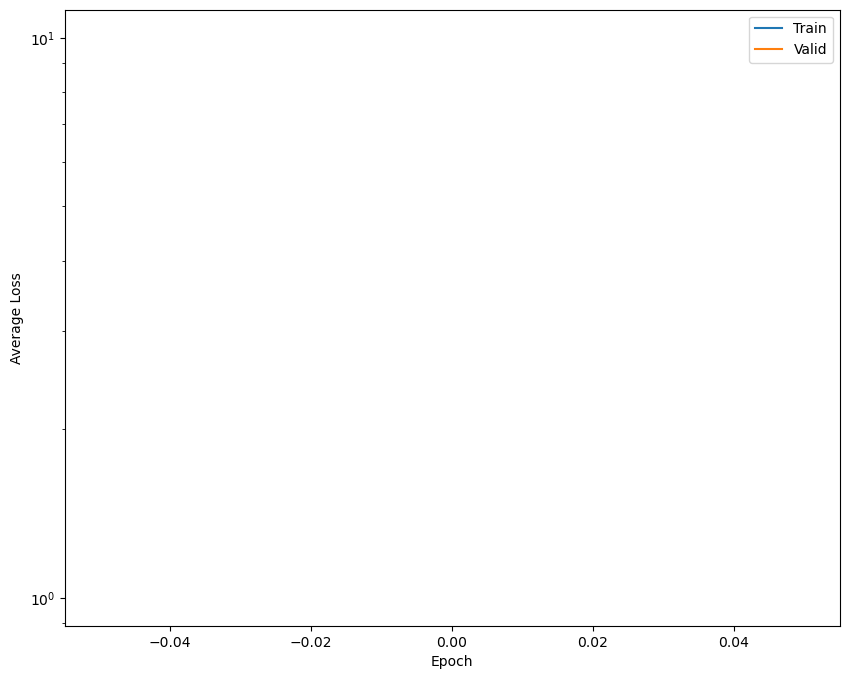

0


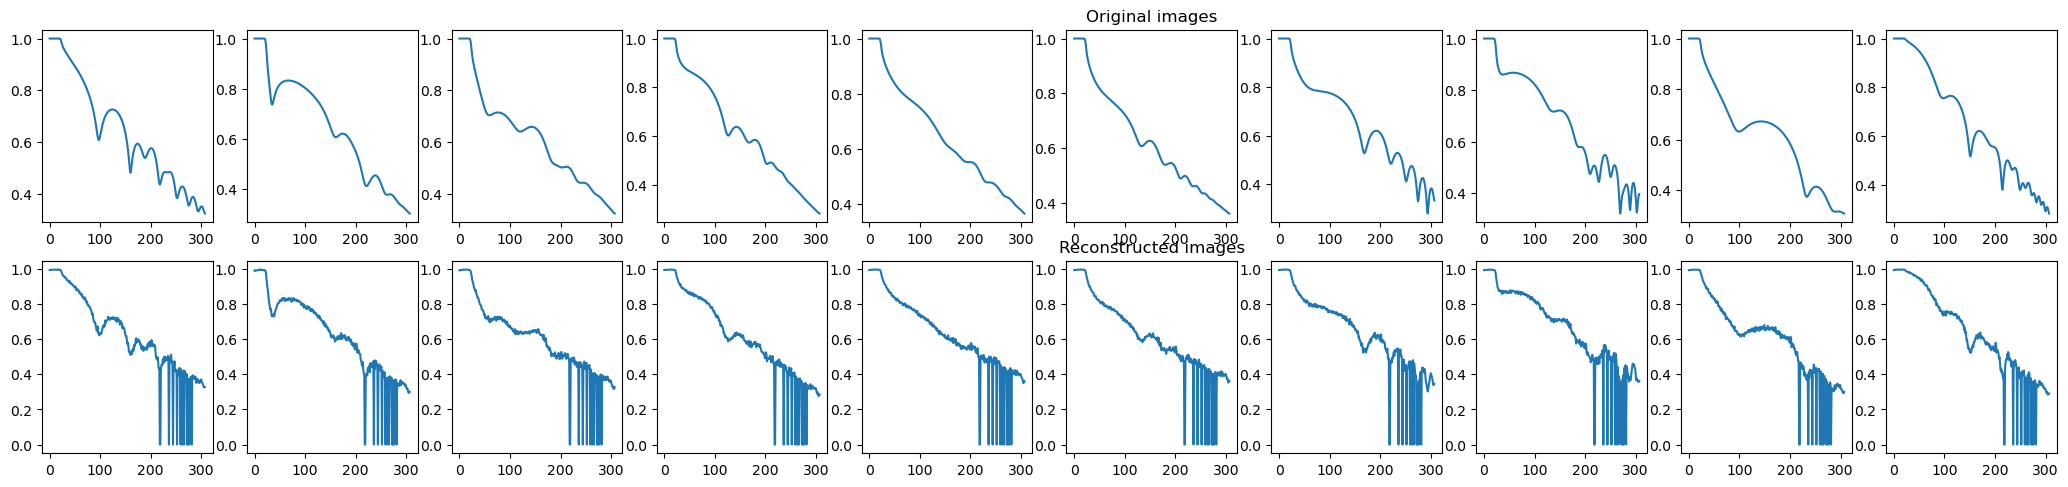

1


KeyboardInterrupt: 

In [20]:
num_epochs=7
#train and validate
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
  if epoch % 10 ==0:
    # Plot losses
        plt.figure(figsize=(10,8))
        plt.semilogy(diz_loss['train_loss'], label='Train')
        plt.semilogy(diz_loss['val_loss'], label='Valid')
        plt.xlabel('Epoch')
        plt.ylabel('Average Loss')
        plt.legend()
        plt.show()
  print (epoch)
  train_loss = fit(encoder,decoder,device,train_loader,loss_fn,optim)
  val_loss = val(encoder,decoder,device,valid_loader,loss_fn)
  diz_loss['train_loss'].append(train_loss)
  diz_loss['val_loss'].append(val_loss)
  plot_outputs(encoder,decoder,dataset,device,n=10)

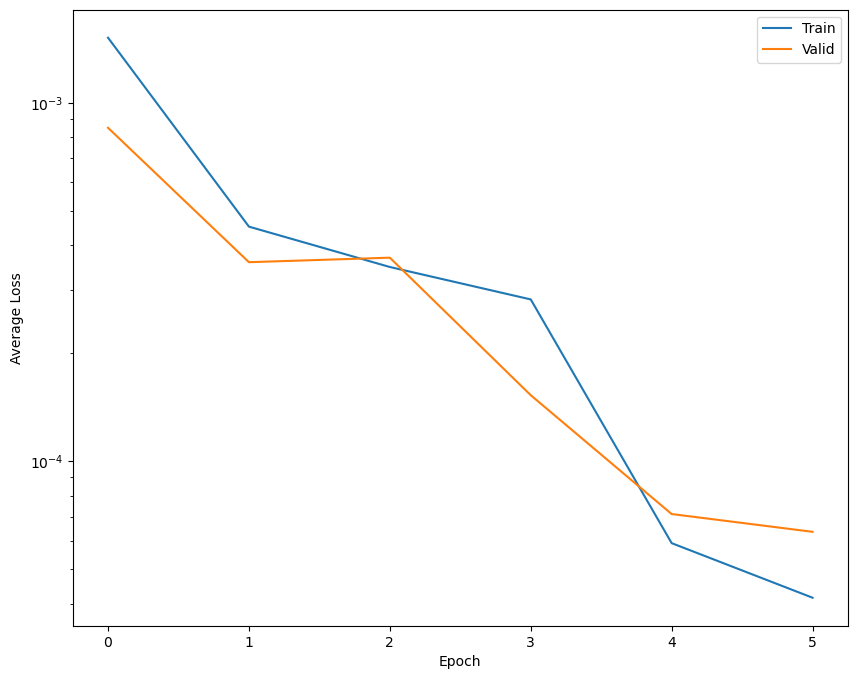

In [21]:
# Plot losses
plt.figure(figsize=(10,8))
plt.semilogy(diz_loss['train_loss'], label='Train')
plt.semilogy(diz_loss['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.legend()
plt.show()


In [25]:
#plotting results after training

def test10(encoder,decoder,dataset,device,loss_fn,n=10):
    plt.figure(figsize=(26,5.5))
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img,_ = dataset[i]
      img = img[:,np.newaxis,:].to(device)
      encoder.eval().to(device)
      decoder.eval().to(device)
      with torch.no_grad():
         decoded_img  = decoder(encoder(img))
         loss = loss_fn(decoded_img,img)
         print('For image {}, the loss = {}'.format(i,loss.data))
      print(img.shape)
      plt.plot(img.cpu()[0][0]) 
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n) 
      plt.plot(decoded_img.cpu()[0][0]) 
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show() 

For image 0, the loss = 4.249667108524591e-05
torch.Size([1, 1, 308])
For image 1, the loss = 5.9501544455997646e-05
torch.Size([1, 1, 308])
For image 2, the loss = 4.599759267875925e-05
torch.Size([1, 1, 308])
For image 3, the loss = 4.513221574597992e-05
torch.Size([1, 1, 308])
For image 4, the loss = 6.614873564103618e-05
torch.Size([1, 1, 308])
For image 5, the loss = 5.039718598709442e-05
torch.Size([1, 1, 308])
For image 6, the loss = 4.261787762516178e-05
torch.Size([1, 1, 308])
For image 7, the loss = 4.120727680856362e-05
torch.Size([1, 1, 308])
For image 8, the loss = 4.068266207468696e-05
torch.Size([1, 1, 308])
For image 9, the loss = 7.420606561936438e-05
torch.Size([1, 1, 308])


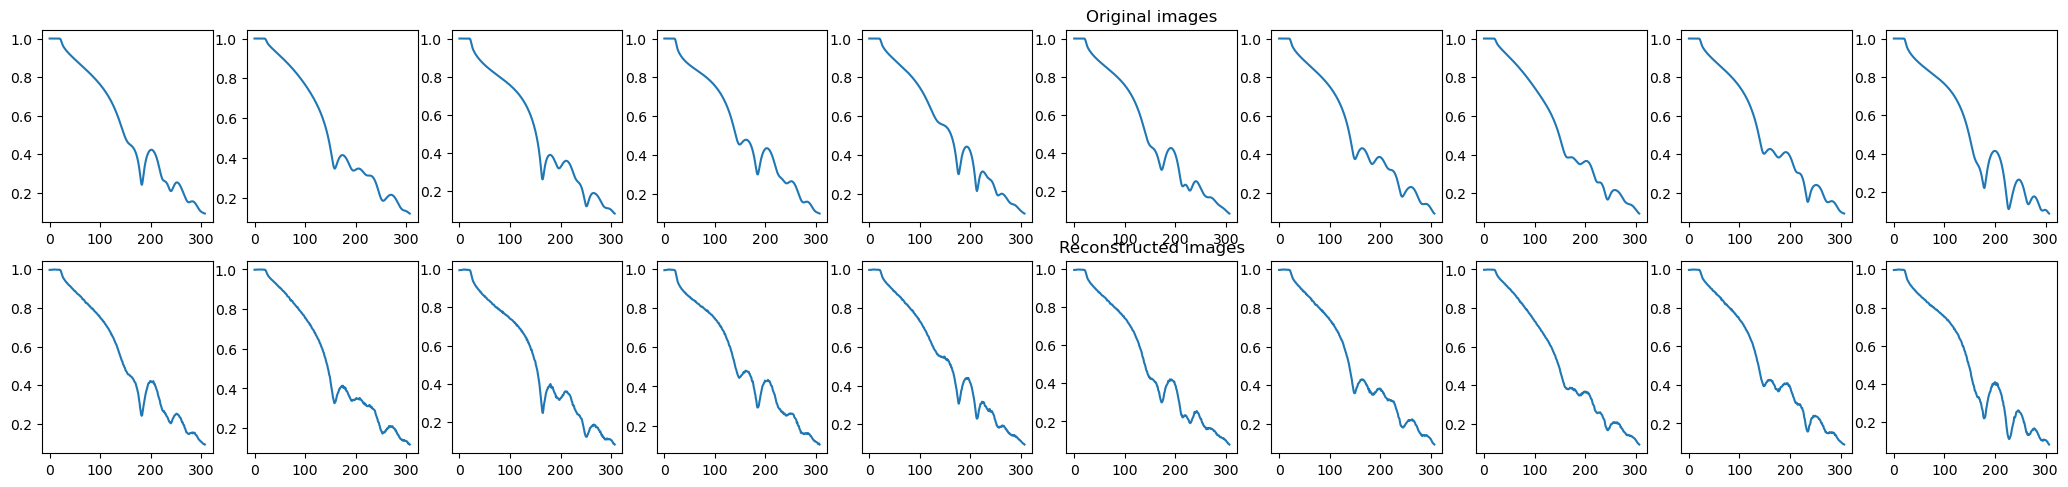

In [26]:
test10(encoder,decoder,test_dataset,device,loss_fn,n=10)


In [51]:
import gdown
gdown.download_folder("https://drive.google.com/drive/folders/1lBIo_aC1yRNW2SYuyzCq7vQOFO0M3DYo")

Retrieving folder list


Processing file 10cLY_gZBBLyspUykzuwyYJRZ_xHlSQcr np_out_REFL_194385_combined_data_auto.npy
Processing file 1-Bg_dDjlyFfjFZVJlk_-e7ijvkDEwrVW np_out_REFL_194395_combined_data_auto.npy
Processing file 106y5IQmOlq4mzsJnTeKuVZY7P_YMBpPU np_out_REFL_194403_combined_data_auto.npy
Processing file 1-5BCbBd-500_61ZLYPkJ39dnkJq0T6TR np_out_REFL_194411_combined_data_auto.npy
Processing file 1-sVMDi3Oiz5YCl9-bVq7D0-mC9UFragB np_out_REFL_194419_combined_data_auto.npy
Processing file 15yvIOnNSoKjuZKuxXp6cLSpiyRgqtS2K np_out_REFL_194426_combined_data_auto.npy
Processing file 1-0n3qmiKTt-GrjRlPifnARqDQ_3ZTxSS np_out_REFL_194438_combined_data_auto.npy
Processing file 1035D9KjhbfLpU8hnwQUI-LqHKeTEuEpK np_out_REFL_194446_combined_data_auto.npy
Processing file 1-Z5SMdG340dBn_Y9xxykuT7xxgGoZ0x7 np_out_REFL_194455_combined_data_auto.npy
Processing file 1-INLTmMBVeENaVhvOG4yI3SCztO4fklM np_out_REFL_194463_combined_data_auto.npy
Processing file 102we8PtrDZz7MGXGD18CdkHIzOPoCALQ np_out_REFL_194471_combined_da

Retrieving folder list completed
Building directory structure


AttributeError: 'NoneType' object has no attribute 'groups'

np_out_REFL_202425_combined_data_auto.npy
np_out_REFL_202461_combined_data_auto.npy
np_out_REFL_202349_combined_data_auto.npy
np_out_REFL_202293_combined_data_auto.npy
np_out_REFL_202314_combined_data_auto.npy
np_out_REFL_202394_combined_data_auto.npy
np_out_REFL_202265_combined_data_auto.npy
np_out_REFL_202272_combined_data_auto.npy
np_out_REFL_202279_combined_data_auto.npy
npoutputsPoly/np_out_REFL_202279_combined_data_auto.npy
np_out_REFL_202253_combined_data_auto.npy
np_out_REFL_202342_combined_data_auto.npy
np_out_REFL_202356_combined_data_auto.npy
np_out_REFL_202454_combined_data_auto.npy
np_out_REFL_202468_combined_data_auto.npy
np_out_REFL_202382_combined_data_auto.npy
np_out_REFL_202286_combined_data_auto.npy
np_out_REFL_202406_combined_data_auto.npy
np_out_REFL_202369_combined_data_auto.npy
np_out_REFL_202437_combined_data_auto.npy
np_out_REFL_202307_combined_data_auto.npy
np_out_REFL_202300_combined_data_auto.npy
np_out_REFL_202413_combined_data_auto.npy


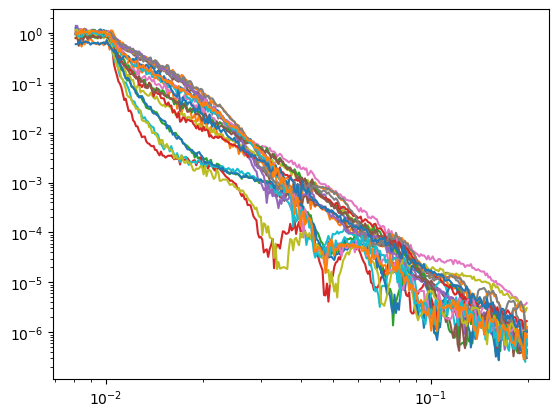

(22, 2, 308)

In [27]:
#Load in Polyzwitterion Experimental Data
import os
directory = "npoutputsPoly/"

totalDataPoly = []
parametersPoly = []
count = 0
for i,filename in enumerate(os.listdir(directory)):
    f = os.path.join(directory, filename)
    if os.path.isfile(f):
        print(f[14:])
    currData = np.load(directory +f[14:])
    xptPoly = []
    yptPoly = []
    parametersPoly.append([])
    for j in range(10):
        parametersPoly[count].append(int(f[26:32]))
    for j in range(len(currData)):
      xptPoly.append(currData[j][0])
      yptPoly.append(currData[j][1])
    np.array(xptPoly)
    np.array(yptPoly)
    totalDataPoly.append([xptPoly,yptPoly])
    if i == 8:
      print(f)
    count += 1
totalDataPoly = np.stack(totalDataPoly)
for x in range(len(totalDataPoly)):
  plt.plot(totalDataPoly[x][0],totalDataPoly[x][1])
plt.xscale('log')
plt.yscale('log')
plt.show()
totalDataPoly = np.log10(totalDataPoly)
totalDataPoly.shape

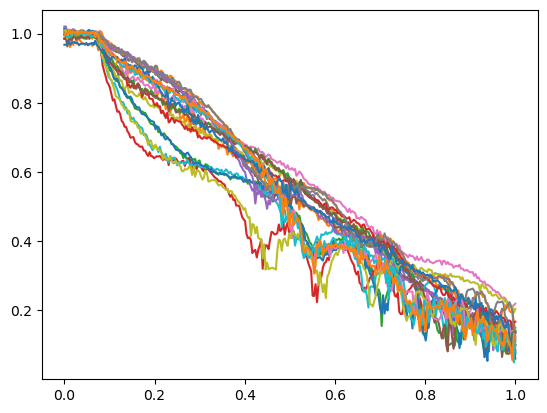

In [28]:
#normalizing experimental data and plotting it again
x_pointsPoly = []
y_pointsPoly = []
for curve in totalDataPoly:
    x_pointsPoly.append(curve[0])
    y_pointsPoly.append(curve[1])
for i in range(len(y_pointsPoly)):
    for j in range(len(y_pointsPoly[0])):
        x_pointsPoly[i][j] -= x_min
        y_pointsPoly[i][j] -= y_min
        x_pointsPoly[i][j] /= (x_max - x_min)
        y_pointsPoly[i][j] /= (y_max - y_min)
totalDataPoly2 = []
for i in range(len(y_pointsPoly)):
    totalDataPoly2.append([x_pointsPoly[i],y_pointsPoly[i]])
totalDataPoly2 = np.stack(totalDataPoly2)
totalDataPoly2.shape
for x in range(totalDataPoly.shape[0]):
  plt.plot(totalDataPoly[x][0],totalDataPoly[x][1])

In [29]:
#splitting experimental data
totalDataPoly.shape
RPoly = totalDataPoly[:,1]
parametersPoly = np.stack(parametersPoly)
batch_size=64
RPoly_m = RPoly[:,np.newaxis,:]
xtrainPoly, ytrainPoly, xvalPoly, yvalPoly, xtestPoly, ytestPoly = \
dpre.split_input_arrays(RPoly_m,parametersPoly, size_split=0.9)
#Prepare data files, continuation
train_datasetPoly, valid_datasetPoly, test_datasetPoly, train_loaderPoly, valid_loaderPoly, test_loaderPoly = \
dpre.get_dataloaders_fromsplitarrays(xtrainPoly,ytrainPoly,xvalPoly,yvalPoly,xtestPoly,ytestPoly,batch_size=batch_size)
print(train_datasetPoly)
for data, label in train_datasetPoly:
    print(label)

xtrain.shape, ytrain.shape, xval.shape, yval.shape, xtest.shape, ytest.shape
(19, 1, 308) (19, 10) (1, 1, 308) (1, 10) (2, 1, 308) (2, 10)
tensor([202279., 202279., 202279., 202279., 202279., 202279., 202279., 202279.,
        202279., 202279.])
tensor([202382., 202382., 202382., 202382., 202382., 202382., 202382., 202382.,
        202382., 202382.])
tensor([202286., 202286., 202286., 202286., 202286., 202286., 202286., 202286.,
        202286., 202286.])
tensor([202369., 202369., 202369., 202369., 202369., 202369., 202369., 202369.,
        202369., 202369.])
tensor([202300., 202300., 202300., 202300., 202300., 202300., 202300., 202300.,
        202300., 202300.])
tensor([202356., 202356., 202356., 202356., 202356., 202356., 202356., 202356.,
        202356., 202356.])
tensor([202394., 202394., 202394., 202394., 202394., 202394., 202394., 202394.,
        202394., 202394.])
tensor([202272., 202272., 202272., 202272., 202272., 202272., 202272., 202272.,
        202272., 202272.])
tenso

In [30]:
#plots experimental NR curves on top and respective SLD prediction below

def plot_outputs3(Encoder, Decoder,dataset,device,loss_fn, n=10, ):
  plt.figure(figsize=(26,5.5))
  train_loss= []
  for i in range(n):
    ax = plt.subplot(2,n,i+1)
    img, label =dataset[i]
    img = img[:,np.newaxis,:].to(device) 
    Encoder.eval().to(device)
    Decoder.eval().to(device)
    with torch.no_grad():
      decoded_img  = Decoder(Encoder(img))
    print(int(label[0].item()))
    plt.plot(img.cpu().numpy()[0][0])
    if i == n//2:
      ax.set_title('Neutron Reflectivity images')
    ax = plt.subplot(2, n, i + 1 + n)
    plt.plot(decoded_img.cpu()[0][0]) 
    if i == n//2:
      ax.set_title('SLD images')
  plt.show()

202279
202382
202286
202369
202300
202356
202394
202272
202468
202437


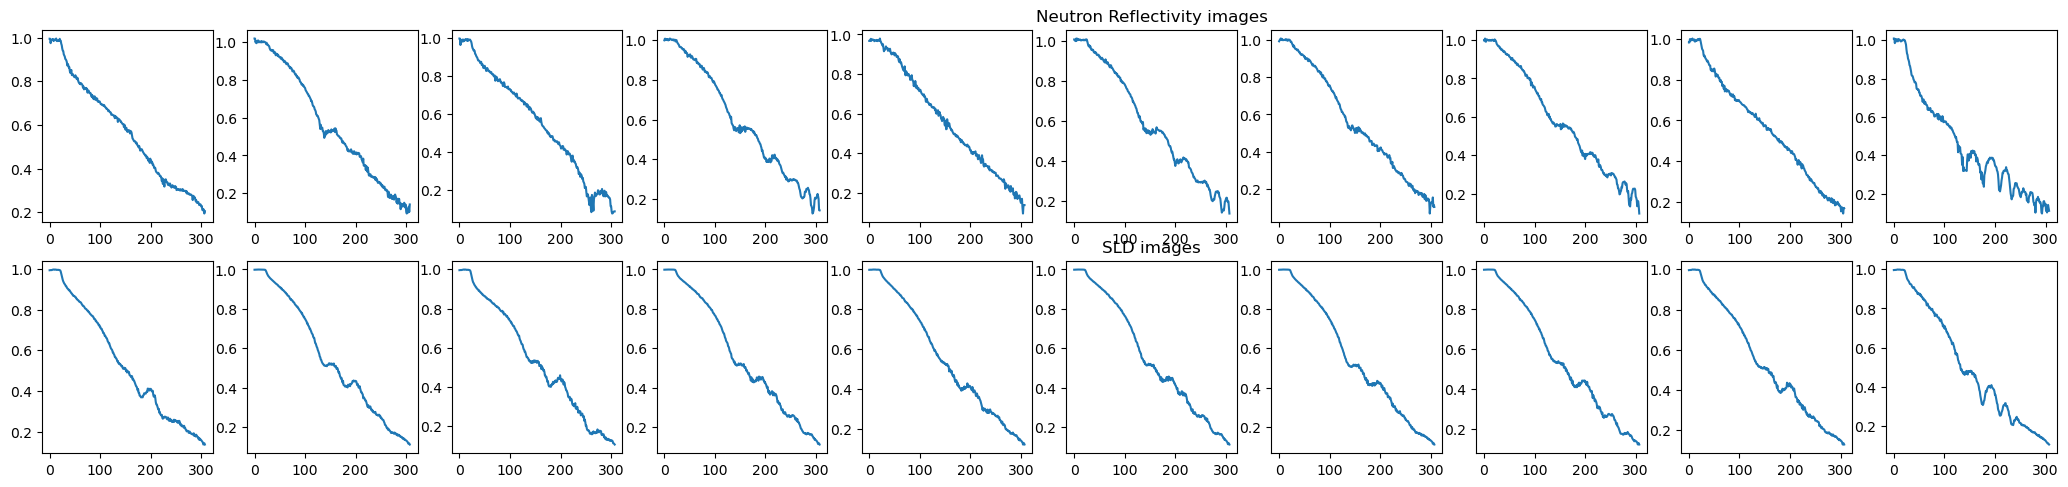

In [31]:
plot_outputs3(encoder, decoder, train_datasetPoly, device, loss_fn)

In [32]:
## Method to take a model and dataloader, and output 4 arrays as pytorch tensors:
## Input curves, output curves, latent space vectors, and chi parameters
def get_latent_variables2(encoder, decoder, device, dataloader):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): 
        # Define the lists to store the original images, the recreated ones,
        # the latent variables and the corresponding labels
        list_img = []
        list_decoded_img = []
        list_latent = []
        list_labels = []

        for  data, label in dataloader:
            img = data
            # print(img.shape)
            img = img.to(device)
            # Encode and Decode data
            latent = encoder(img)
            decoded_img = decoder(latent)
            # Append the network output and the original image to the lists
            list_img.append(img.cpu())
            list_decoded_img.append(decoded_img.cpu())
            list_latent.append(latent.cpu())
            list_labels.append(label.cpu())
# Convert list into a torch.tensor
        t_img = torch.cat(list_img)
        t_decoded_img = torch.cat(list_decoded_img)
        t_latent = torch.cat(list_latent) 
        t_labels = torch.cat(list_labels)
    return t_img, t_decoded_img, t_latent, t_labels

In [33]:
def get_dataloaders2(crv_tr, chi_tr, crv_val, chi_val, crv_tst, chi_tst, batch_size):

    tr_set = torch.utils.data.TensorDataset(crv_tr, chi_tr)
    tr_load = torch.utils.data.DataLoader(tr_set, batch_size = batch_size, shuffle = True)

    val_set = torch.utils.data.TensorDataset(crv_val, chi_val)
    val_load = torch.utils.data.DataLoader(val_set, batch_size = batch_size, shuffle = True)

    tst_set = torch.utils.data.TensorDataset(crv_tst, chi_tst)
    tst_load = torch.utils.data.DataLoader(tst_set, batch_size = batch_size, shuffle = True)

    return [tr_set, val_set, tst_set, tr_load, val_load, tst_load]

In [34]:
#data splitting
print(R_m.shape)
print(params_nr.shape)
xtrain, ytrain, xval, yval, xtest, ytest = \
dpre.split_input_arrays(R_m,params_nr, size_split=0.9)
#Prepare data files, continuation
train_dataset, valid_dataset, test_dataset, train_loader, valid_loader, test_loader = \
dpre.get_dataloaders_fromsplitarrays(xtrain,ytrain,xval,yval,xtest,ytest,batch_size=batch_size)


(100000, 1, 308)
(100000, 11)
xtrain.shape, ytrain.shape, xval.shape, yval.shape, xtest.shape, ytest.shape
(90000, 1, 308) (90000, 11) (5000, 1, 308) (5000, 11) (5000, 1, 308) (5000, 11)


In [35]:
#obtaining latency space of each NR curve to be compared with the parameters for MLP

full_data_train = get_latent_variables2(encoder,decoder,device,train_loader)
full_data_valid = get_latent_variables2(encoder,decoder,device,valid_loader)
full_data_test = get_latent_variables2(encoder,decoder,device,test_loader)
mlp_input_data = [full_data_train[2], full_data_train[3], full_data_valid[2], full_data_valid[3], full_data_test[2], full_data_test[3]]
device
# print(full_data_train[2])

device(type='cuda')

In [36]:
#more data splitting
mlp_tr_data, mlp_val_data, mlp_tst_data, mlp_tr_load, mlp_val_load, mlp_tst_load = get_dataloaders2(*mlp_input_data, batch_size)

In [37]:
import refl1d
from refl1d.names import *

In [38]:
#MLP Structure

class deep_MLP2(nn.Module):
    def __init__(self, input_size, n_label):
        super().__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_size, 300))
        self.layers.append(nn.BatchNorm1d(300))
        self.layers.append(nn.ReLU(True))
        self.layers.append(nn.Linear(300, 500))
        self.layers.append(nn.BatchNorm1d(500))
        self.layers.append(nn.ReLU(True))
        self.layers.append(nn.Linear(500, 300))
        self.layers.append(nn.BatchNorm1d(300))
        self.layers.append(nn.ReLU(True))
        self.layers.append(nn.Linear(300, 120))
        self.layers.append(nn.BatchNorm1d(120))
        self.layers.append(nn.ReLU(True))
        self.layers.append(nn.Linear(120,60))
        self.layers.append(nn.BatchNorm1d(60))
        self.layers.append(nn.ReLU(True))
        self.layers.append(nn.Linear(60, n_label))
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x= torch.sigmoid(x)
        return x

In [39]:
#Training function for MLP

def trainMLP(model, train_loader, val_loader, epochs, loss_fn, ranger):
    model.train()
    opt = torch.optim.Adam(model.parameters(), lr = 0.0001)
    train_loss = []
    val_loss = []
    for epoch in range(epochs):
        shot_loss = []
        count = 0
        for data, label in train_loader:
            data = data.to(device)
            label = label.to(device)
            opt.zero_grad()
            output = model(data)
            loss = loss_fn(output, label)
            loss.backward()
            opt.step()
            shot_loss.append(loss.item())
            count += 1
        epoch_loss = np.mean(shot_loss)
        train_loss.append(epoch_loss)

        model.eval()
        with torch.no_grad():
            val_shot_loss = []
            for data, label in val_loader:
                data = data.to(device)
                label = label.to(device)
                output = model(data)
                loss = loss_fn(output, label)
                val_shot_loss.append(loss.item())
            val_epoch_loss = np.mean(val_shot_loss)
            val_loss.append(val_epoch_loss)

        print('Epoch: ' + str(epoch + 1) + ', train loss: ' + str(epoch_loss) + ', valid loss: ' + str(val_epoch_loss))
    
    return train_loss, val_loss

In [56]:
#training

percep = deep_MLP2(d, 11).cuda()
print(d)
train_loss, val_loss = trainMLP(percep, mlp_tr_load, mlp_val_load, 40, loss_fn, ranges)

200
Epoch: 1, train loss: 0.028757160608924782, valid loss: 0.016459172603355932
Epoch: 2, train loss: 0.01346740076303821, valid loss: 0.012606405193292642
Epoch: 3, train loss: 0.011531390092192005, valid loss: 0.0116578788154676
Epoch: 4, train loss: 0.010633629578938172, valid loss: 0.010980463993464466
Epoch: 5, train loss: 0.00995673067926005, valid loss: 0.010455273545665455
Epoch: 6, train loss: 0.0094572437265868, valid loss: 0.010096284943998238
Epoch: 7, train loss: 0.009077793563760463, valid loss: 0.009673567099756078
Epoch: 8, train loss: 0.00867388509518408, valid loss: 0.011173135424150696
Epoch: 9, train loss: 0.008398190698392462, valid loss: 0.009496241955298789
Epoch: 10, train loss: 0.008112839245725246, valid loss: 0.0105746023745948
Epoch: 11, train loss: 0.00786991248717472, valid loss: 0.008675845699455542
Epoch: 12, train loss: 0.007660651300168664, valid loss: 0.008858590097980032
Epoch: 13, train loss: 0.007410736840255373, valid loss: 0.008573214499916456
E

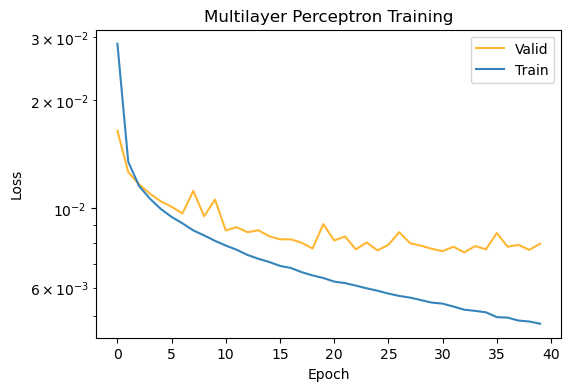

In [57]:
#plotting loss

plt.figure(figsize=(6,4))
plt.semilogy(val_loss, label='Valid', color = 'orange', alpha=0.8)
plt.semilogy(train_loss, label='Train', alpha=.9)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Multilayer Perceptron Training')
plt.legend()

In [58]:
#unnormalizing output parameters

def unnormalizeParams(params, ranger):
    for i in range(len(ranger)):
        for j in range(len(params)):
            params[j][i] *= (ranger[i][1]-ranger[i][0])
            params[j][i] += ranger[i][0]
    return params

In [59]:
#testing accuracy on training data

train_samples = []

for i, sample in enumerate(mlp_tr_data):
    if i > 0:
        break
    latent = sample[0].to(device)
    latent = latent[np.newaxis,:]
    label_val = sample[1].to(device)
    percep.eval()
    with torch.no_grad():
        output  = percep(latent)
    out_sample = {"parameter"+str(i+1): enc for i, enc in enumerate(output)}
    for i in range(11):
      label_index = 'parameter'+str(i+1)
      out_sample[label_index] = [output[0][i],label_val[i]]
    train_samples.append(out_sample)
print(train_samples[0])

{'parameter1': [tensor(0.1048, device='cuda:0'), tensor(0.3100, device='cuda:0')], 'parameter2': [tensor(0.7378, device='cuda:0'), tensor(0.9179, device='cuda:0')], 'parameter3': [tensor(0.7235, device='cuda:0'), tensor(0.7045, device='cuda:0')], 'parameter4': [tensor(0.1169, device='cuda:0'), tensor(0.1235, device='cuda:0')], 'parameter5': [tensor(0.4819, device='cuda:0'), tensor(0.1851, device='cuda:0')], 'parameter6': [tensor(0.4516, device='cuda:0'), tensor(0.4350, device='cuda:0')], 'parameter7': [tensor(0.5015, device='cuda:0'), tensor(0.4910, device='cuda:0')], 'parameter8': [tensor(0.0966, device='cuda:0'), tensor(0.0743, device='cuda:0')], 'parameter9': [tensor(0.9037, device='cuda:0'), tensor(0.8669, device='cuda:0')], 'parameter10': [tensor(0.1527, device='cuda:0'), tensor(0.1695, device='cuda:0')], 'parameter11': [tensor(0.9238, device='cuda:0'), tensor(0.8870, device='cuda:0')]}


In [60]:
#testing accuracy on experimental data

train_samplesExperimental = []
for data, label in train_datasetPoly:
    img = data.to(device)
    label_val = label
    encoder.eval()
    img = img[:,np.newaxis,:].to(device)
    latent = encoder(img)
    percep.eval()
    with torch.no_grad():
        out_label  = percep(latent)
    out_label = out_label.cpu().numpy()
    out_sample = {"parameter"+str(i+1): enc for i, enc in enumerate(out_label)}
    out_label = unnormalizeParams(out_label, ranges)
    for i in range(11):
      label_index = 'parameter'+str(i+1)
      out_sample[label_index] = out_label[0][i]
    train_samplesExperimental.append([out_sample, label_val[0]])
    if int(label_val[0].item()) == 202307:
        print(repr(out_label))
print(train_samplesExperimental[0])

array([[  9.892093 ,   4.4124928,   1.2940228,  26.907848 ,  13.321233 ,
          2.1229908, 111.975746 ,  14.413167 ,   3.5927157, 154.1923   ,
         25.867321 ]], dtype=float32)
[{'parameter1': 10.696182, 'parameter2': 4.3885536, 'parameter3': 0.8370868, 'parameter4': 15.479184, 'parameter5': 12.079581, 'parameter6': 2.1248667, 'parameter7': 114.58423, 'parameter8': 14.165549, 'parameter9': 3.3069334, 'parameter10': 143.19138, 'parameter11': 22.798927}, tensor(202279.)]


In [53]:
# torch.save(encoder, "../Autoencoder202307/encoder")

In [54]:
# torch.save(decoder, "../Autoencoder202307/decoder")

In [55]:
# torch.save(percep, "../Autoencoder202307/MLP")

In [48]:
# encoder=torch.load("../3LayerAutoencoder/encoder",map_location='cuda')
# encoder.eval()
# loss_fn = torch.nn.MSELoss()

In [49]:
# decoder=torch.load("../3LayerAutoencoder/decoder",map_location='cuda')
# decoder.eval()
# loss_fn = torch.nn.MSELoss()

In [50]:
# percep=torch.load("../3LayerAutoencoder/MLP",map_location='cuda')
# percep.eval()
# loss_fn = torch.nn.MSELoss()